In [8]:
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import cv2
import imutils
import matplotlib.pyplot as plt
import os
from os import listdir
import time    


%matplotlib inline

In [9]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [10]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    #from keras.preprocessing.image import ImageDataGenerator
    #from os import listdir
    
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in listdir(file_dir):
        # load the image
        image = cv2.imread(file_dir + '\\' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [11]:
import time
from keras.preprocessing.image import ImageDataGenerator
import os
start_time = time.time()

augmented_data_path = 'C:\\Users\\Ayush Kumar\\Desktop\\Brain Tumor\\Brain-Tumor-Detection-master\\Dataset\\'
yes_path = "C:\\Users\\Ayush Kumar\\Desktop\\Brain Tumor\\Brain-Tumor-Detection-master\\Dataset\\yes\\"
no_path = "C:\\Users\\Ayush Kumar\\Desktop\\Brain Tumor\\Brain-Tumor-Detection-master\\Dataset\\no\\"
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:2:10.8


In [12]:
def data_summary(main_path):
    
    yes_path = main_path+'yes'
    no_path = main_path+'no'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 

In [13]:
data_summary(augmented_data_path)

Number of examples: 1779
Percentage of positive examples: 69.70207982012367%, number of pos examples: 1240
Percentage of negative examples: 30.297920179876336%, number of neg examples: 539


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [15]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In [18]:
try:
    ex_img = cv2.imread('C:\\Users\\Ayush Kumar\\Desktop\\Brain Tumor\\Brain-Tumor-Detection-master\\Dataset\\yes\\aug_Y4_0_1037')
    if ex_img is None:
        raise Exception("Failed to load image")
    ex_new_img = crop_brain_contour(ex_img, True)
except Exception as e:
    print(f"Error: {str(e)}")

Error: Failed to load image


In [22]:
ex_img = cv2.imread('C:\\Users\\Ayush Kumar\\Desktop\\Brain Tumor\\Brain-Tumor-Detection-master\\Dataset\\yes\\aug_Y4_0_1037')
ex_new_img = crop_brain_contour(ex_img, True)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [23]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [24]:
augmented_path = 'C:\\Users\\Ayush Kumar\\Desktop\\Brain Tumor\\Brain-Tumor-Detection-master\\Dataset\\'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1779
X shape is: (1779, 240, 240, 3)
y shape is: (1779, 1)


In [25]:
def plot_sample_images(X, y, n=20):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 5
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

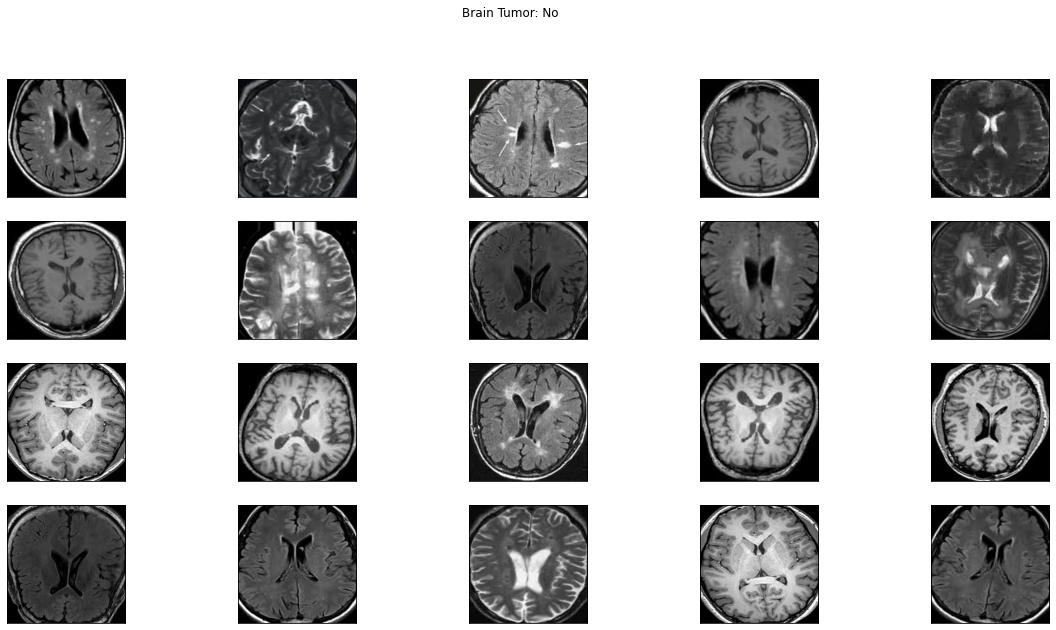

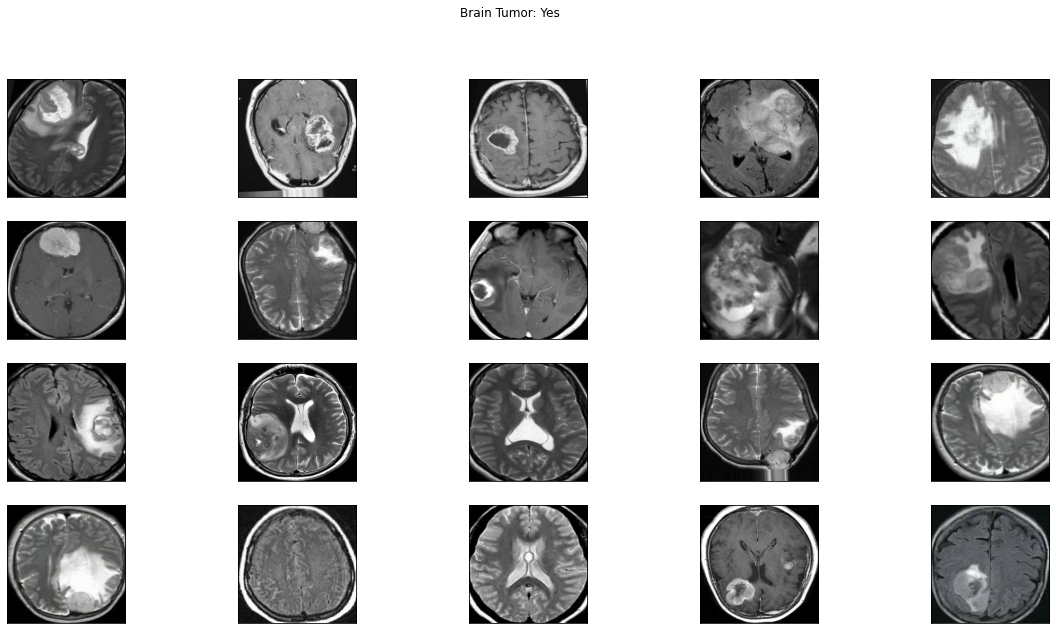

In [26]:
plot_sample_images(X, y)

In [27]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [28]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [29]:
import numpy as np
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1245
number of development examples = 267
number of test examples = 267
X_train shape: (1245, 240, 240, 3)
Y_train shape: (1245, 1)
X_val (dev) shape: (267, 240, 240, 3)
Y_val (dev) shape: (267, 1)
X_test shape: (267, 240, 240, 3)
Y_test shape: (267, 1)


In [30]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [31]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [32]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)

In [33]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs\\{log_file_name}')

In [36]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.model", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [37]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=15, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/15
39/39 [==============================] - ETA: 0s - loss: 0.8295 - accuracy: 0.6859
Epoch 1: val_accuracy improved from -inf to 0.68165, saving model to models\cnn-parameters-improvement-01-0.68.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.68.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.68.model\assets


39/39 [==============================] - 69s 2s/step - loss: 0.8295 - accuracy: 0.6859 - val_loss: 0.6038 - val_accuracy: 0.6816
Epoch 2/15
39/39 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.7807
Epoch 2: val_accuracy did not improve from 0.68165
39/39 [==============================] - 63s 2s/step - loss: 0.4524 - accuracy: 0.7807 - val_loss: 0.6520 - val_accuracy: 0.6255
Epoch 3/15
39/39 [==============================] - ETA: 0s - loss: 0.3799 - accuracy: 0.8394
Epoch 3: val_accuracy improved from 0.68165 to 0.77528, saving model to models\cnn-parameters-improvement-03-0.78.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.78.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.78.model\assets


39/39 [==============================] - 64s 2s/step - loss: 0.3799 - accuracy: 0.8394 - val_loss: 0.5421 - val_accuracy: 0.7753
Epoch 4/15
39/39 [==============================] - ETA: 0s - loss: 0.3112 - accuracy: 0.8659
Epoch 4: val_accuracy improved from 0.77528 to 0.80899, saving model to models\cnn-parameters-improvement-04-0.81.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.81.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.81.model\assets


39/39 [==============================] - 64s 2s/step - loss: 0.3112 - accuracy: 0.8659 - val_loss: 0.4725 - val_accuracy: 0.8090
Epoch 5/15
39/39 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.8980
Epoch 5: val_accuracy did not improve from 0.80899
39/39 [==============================] - 63s 2s/step - loss: 0.2672 - accuracy: 0.8980 - val_loss: 0.5188 - val_accuracy: 0.7603
Epoch 6/15
39/39 [==============================] - ETA: 0s - loss: 0.2911 - accuracy: 0.8892
Epoch 6: val_accuracy improved from 0.80899 to 0.83895, saving model to models\cnn-parameters-improvement-06-0.84.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.84.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.84.model\assets


39/39 [==============================] - 64s 2s/step - loss: 0.2911 - accuracy: 0.8892 - val_loss: 0.4037 - val_accuracy: 0.8390
Epoch 7/15
39/39 [==============================] - ETA: 0s - loss: 0.2181 - accuracy: 0.9253
Epoch 7: val_accuracy did not improve from 0.83895
39/39 [==============================] - 63s 2s/step - loss: 0.2181 - accuracy: 0.9253 - val_loss: 0.4574 - val_accuracy: 0.7753
Epoch 8/15
39/39 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9213
Epoch 8: val_accuracy did not improve from 0.83895
39/39 [==============================] - 63s 2s/step - loss: 0.2014 - accuracy: 0.9213 - val_loss: 0.4525 - val_accuracy: 0.7790
Epoch 9/15
39/39 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.9269
Epoch 9: val_accuracy improved from 0.83895 to 0.85768, saving model to models\cnn-parameters-improvement-09-0.86.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.86.model\assets


39/39 [==============================] - 64s 2s/step - loss: 0.2016 - accuracy: 0.9269 - val_loss: 0.3251 - val_accuracy: 0.8577
Epoch 10/15
39/39 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9470
Epoch 10: val_accuracy did not improve from 0.85768
39/39 [==============================] - 62s 2s/step - loss: 0.1733 - accuracy: 0.9470 - val_loss: 0.3639 - val_accuracy: 0.8352
Epoch 11/15
39/39 [==============================] - ETA: 0s - loss: 0.1689 - accuracy: 0.9349
Epoch 11: val_accuracy did not improve from 0.85768
39/39 [==============================] - 67s 2s/step - loss: 0.1689 - accuracy: 0.9349 - val_loss: 0.3366 - val_accuracy: 0.8464
Epoch 12/15
39/39 [==============================] - ETA: 0s - loss: 0.1361 - accuracy: 0.9598
Epoch 12: val_accuracy improved from 0.85768 to 0.89139, saving model to models\cnn-parameters-improvement-12-0.89.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-12-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-12-0.89.model\assets


39/39 [==============================] - 65s 2s/step - loss: 0.1361 - accuracy: 0.9598 - val_loss: 0.2587 - val_accuracy: 0.8914
Epoch 13/15
39/39 [==============================] - ETA: 0s - loss: 0.1805 - accuracy: 0.9277
Epoch 13: val_accuracy did not improve from 0.89139
39/39 [==============================] - 63s 2s/step - loss: 0.1805 - accuracy: 0.9277 - val_loss: 0.2952 - val_accuracy: 0.8876
Epoch 14/15
39/39 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.9647
Epoch 14: val_accuracy did not improve from 0.89139
39/39 [==============================] - 63s 2s/step - loss: 0.1160 - accuracy: 0.9647 - val_loss: 0.2818 - val_accuracy: 0.8727
Epoch 15/15
39/39 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9703
Epoch 15: val_accuracy improved from 0.89139 to 0.89888, saving model to models\cnn-parameters-improvement-15-0.90.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-15-0.90.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-15-0.90.model\assets


39/39 [==============================] - 66s 2s/step - loss: 0.1017 - accuracy: 0.9703 - val_loss: 0.2651 - val_accuracy: 0.8989
Elapsed time: 0:16:7.7


In [37]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
51/51 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9519
Epoch 1: val_accuracy improved from 0.87931 to 0.89368, saving model to models\cnn-parameters-improvement-01-0.89.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.89.model\assets


51/51 [==============================] - 105s 2s/step - loss: 0.1333 - accuracy: 0.9519 - val_loss: 0.3109 - val_accuracy: 0.8937
Epoch 2/3
51/51 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9760
Epoch 2: val_accuracy did not improve from 0.89368
51/51 [==============================] - 86s 2s/step - loss: 0.0937 - accuracy: 0.9760 - val_loss: 0.3192 - val_accuracy: 0.8879
Epoch 3/3
51/51 [==============================] - ETA: 0s - loss: 0.0990 - accuracy: 0.9723
Epoch 3: val_accuracy did not improve from 0.89368
51/51 [==============================] - 85s 2s/step - loss: 0.0990 - accuracy: 0.9723 - val_loss: 0.3456 - val_accuracy: 0.8937
Elapsed time: 0:4:51.8


In [38]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
39/39 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 0.9711
Epoch 1: val_accuracy improved from 0.89888 to 0.92884, saving model to models\cnn-parameters-improvement-01-0.93.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.93.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.93.model\assets


39/39 [==============================] - 68s 2s/step - loss: 0.1051 - accuracy: 0.9711 - val_loss: 0.2145 - val_accuracy: 0.9288
Epoch 2/3
39/39 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.9679
Epoch 2: val_accuracy did not improve from 0.92884
39/39 [==============================] - 63s 2s/step - loss: 0.1055 - accuracy: 0.9679 - val_loss: 0.1992 - val_accuracy: 0.9251
Epoch 3/3
39/39 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9855
Epoch 3: val_accuracy did not improve from 0.92884
39/39 [==============================] - 63s 2s/step - loss: 0.0704 - accuracy: 0.9855 - val_loss: 0.1909 - val_accuracy: 0.9176
Elapsed time: 0:3:21.8


In [49]:
history = model.history.history
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [53]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile()
metrics=['accuracy']

In [57]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

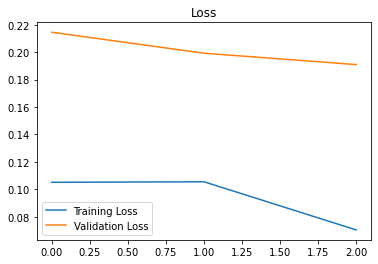

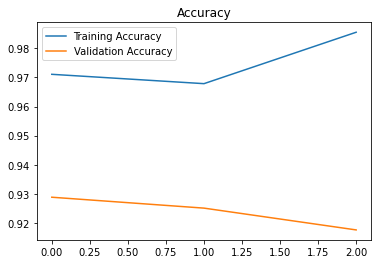

In [58]:
plot_metrics(history) 

In [59]:
Results
Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 23rd iteration with validation accuracy of 91%

Load the best model¶

SyntaxError: EOL while scanning string literal (Temp/ipykernel_23992/953410192.py, line 2)

In [61]:
best_model = load_model(filepath='models/cnn-parameters-improvement-23-0.91.model')

In [62]:
best_model.metrics_names

['loss', 'accuracy']

In [63]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

9/9 [==============================] - 6s 562ms/step - loss: 0.3463 - accuracy: 0.9026


In [64]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.34625551104545593
Test Accuracy = 0.9026217460632324


In [65]:
y_test_prob = best_model.predict(X_test)

9/9 [==============================] - 11s 555ms/step


In [72]:
f1score = compute_f1_score(y_test, y_test_prob)
print("F1 score:",{f1score})

F1 score: {0.9230769230769231}


In [73]:
y_val_prob = best_model.predict(X_val)

9/9 [==============================] - 5s 543ms/step


In [74]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9005847953216375


In [76]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 


In [77]:
# the whole data
data_percentage(y)

Number of examples: 1779
Percentage of positive examples: 69.70207982012367%, number of pos examples: 1240
Percentage of negative examples: 30.297920179876336%, number of neg examples: 539


In [78]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1245
Percentage of positive examples: 70.52208835341365%, number of pos examples: 878
Percentage of negative examples: 29.477911646586346%, number of neg examples: 367
Validation Data:
Number of examples: 267
Percentage of positive examples: 68.91385767790263%, number of pos examples: 184
Percentage of negative examples: 31.086142322097377%, number of neg examples: 83
Testing Data:
Number of examples: 267
Percentage of positive examples: 66.66666666666667%, number of pos examples: 178
Percentage of negative examples: 33.333333333333336%, number of neg examples: 89


In [1]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_metrics(history, y_true, y_pred):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


In [6]:
cm = confusion_matrix(y_test, Y_test_prob)

# Visualize the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

NameError: name 'y_test' is not defined